# Imports

In [1037]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

## Load Data

In [1038]:
data = pd.read_csv("data.csv", sep=";")

data.head()

,initial,angle,landing,position_x,position_y
0,tails,0,tails,-10,-4
1,tails,0,heads,-5,2
2,tails,0,heads,-11,-2
3,tails,0,tails,-8,-1
4,tails,0,tails,-10,2


In [1039]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   initial     100 non-null    object
 1   angle       100 non-null    int64 
 2   landing     100 non-null    object
 3   position_x  100 non-null    int64 
 4   position_y  100 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 4.0+ KB


**Split data into train and test sets:**

In [1040]:
# from sklearn.model_selection import train_test_split
# train_data, test_data = train_test_split(data, test_size=0.2)

from sklearn.model_selection import StratifiedShuffleSplit   # this splits wayyyy better

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_ids, test_ids in split.split(data, data["angle"]):
    train_data = data.loc[train_ids].copy()
    test_data = data.loc[test_ids].copy()

In [1041]:
train_data.describe()

,angle,position_x,position_y
count,80.000000,80.000000,80.000000
mean,85.312500,-5.312500,-1.812500
std,59.551827,6.883467,8.036458
min,0.000000,-23.000000,-39.000000
25%,45.000000,-8.000000,-3.250000
50%,75.000000,-6.000000,-1.000000
75%,135.000000,-4.000000,1.250000
max,180.000000,23.000000,16.000000


In [1042]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80 entries, 63 to 33
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   initial     80 non-null     object
 1   angle       80 non-null     int64 
 2   landing     80 non-null     object
 3   position_x  80 non-null     int64 
 4   position_y  80 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 3.8+ KB


In [1043]:
# y_train = train_data.drop(["landing", "position_x", "position_y"], axis=1)
# y_test = test_data.drop(["landing", "position_x", "position_y"], axis=1)

# y_train = train_data.pop("landing")
# y_test = test_data.pop("landing")

## Data Visualization

**Histogram of Initial Orientations:**

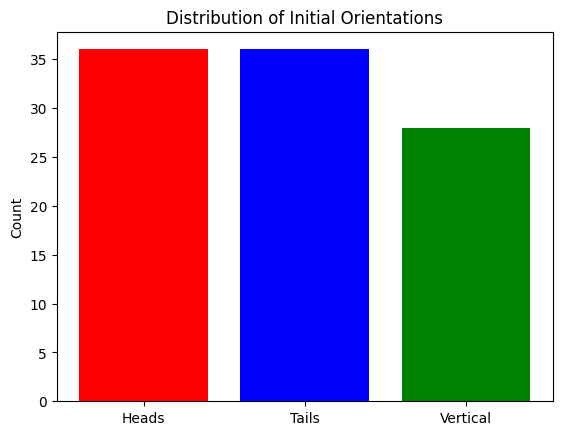

In [1044]:
labels = {'heads': 'Heads', 'tails': 'Tails', 'vertical (tails facing me)': 'Vertical'}
plt.bar(labels.values(), data['initial'].value_counts(), color=['red', 'blue', 'green'])
plt.ylabel('Count')
plt.title('Distribution of Initial Orientations')
plt.show()

**Scatter Plot of Landing Positions:**

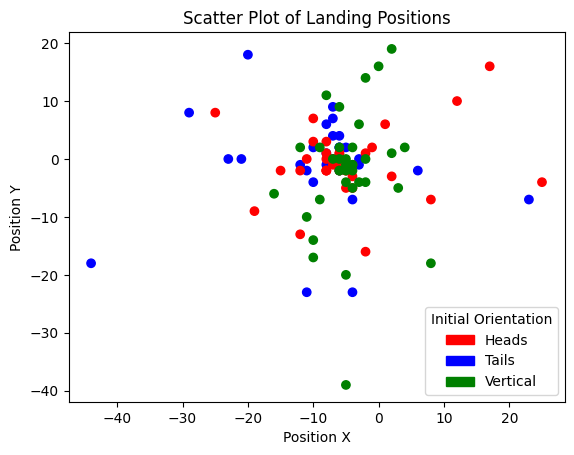

In [1045]:
from matplotlib.patches import Patch

colors = data['initial'].map({'heads': 'red', 'tails': 'blue', 'vertical (tails facing me)': 'green'})

scatter_plot = plt.scatter(data['position_x'], data['position_y'], c=colors)
plt.xlabel('Position X')
plt.ylabel('Position Y')
plt.title('Scatter Plot of Landing Positions')

legend_handles = [Patch(color='red', label='Heads'),
                  Patch(color='blue', label='Tails'),
                  Patch(color='green', label='Vertical')]

plt.legend(handles=legend_handles, loc='lower right', title='Initial Orientation')
plt.show()


**Histogram of Dropping Angles:**

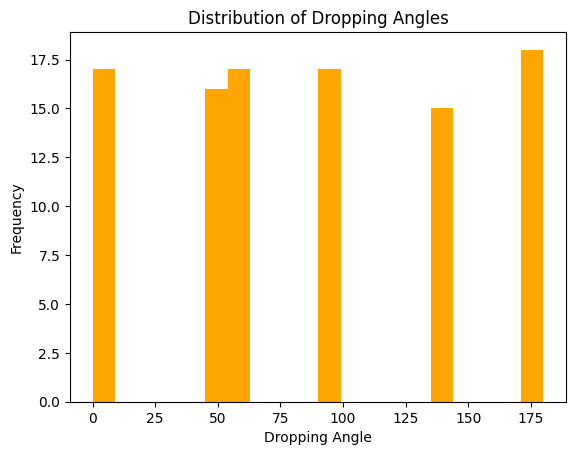

In [1046]:
plt.hist(data['angle'], bins=20, color='orange')
plt.xlabel('Dropping Angle')
plt.ylabel('Frequency')
plt.title('Distribution of Dropping Angles')
plt.show()

## Data Preprocessing

I will utilize 2 seperate models:
- A binary classifier for landing orientation
- A multiple output regressor for landing position (x,y)

Seperate the columns for each model. The input columns are same for both models.

In [1047]:
# Inputs
X_train = train_data[['initial', 'angle']]
X_test = test_data[['initial', 'angle']]

# Outputs
y_train_landing = train_data['landing']
y_test_landing = test_data['landing']

y_train_position = train_data[['position_x', 'position_y']]
y_test_position = test_data[['position_x', 'position_y']]

Some preprocessing, especially on categorical values.

In [1048]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_features = ['angle']
categorical_features = ['initial']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Building the Model

Define the models

In [1049]:
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

classifier_model = RandomForestClassifier(n_estimators=100) #, random_state=10)
regressor_model = RandomForestRegressor(n_estimators=100) #, random_state=10)

Create a pipeline for each model

In [1050]:
from sklearn.pipeline import Pipeline

classifier_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', classifier_model)])

regressor_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', regressor_model)])

## Train the Model

In [1051]:
classifier_pipeline.fit(X_train, y_train_landing)
regressor_pipeline.fit(X_train, y_train_position)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['angle']),
                                                 ('cat', OneHotEncoder(),
                                                  ['initial'])])),
                ('regressor', RandomForestRegressor())])

## Predictions and Accuracy

In [1052]:
y_pred_landing = classifier_pipeline.predict(X_test)
y_pred_position = regressor_pipeline.predict(X_test)

In [1053]:
# Access individual model components if necessary
classifier_model = classifier_pipeline.named_steps['classifier']
regressor_model = regressor_pipeline.named_steps['regressor']

Accuracy of landing position is measured as distance

In [1054]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

accuracy_landing = accuracy_score(y_test_landing, y_pred_landing)

print("Binary Classification ('landing') Evaluation:")
print(f"Accuracy: {accuracy_landing:.4f}")

# calculate distance accuracy
y_test_position_values = y_test_position.values
y_pred_position_values = y_pred_position

distance_position = np.sqrt(mean_squared_error(y_test_position_values, y_pred_position_values))

percentage_accuracy = (1 - distance_position / (y_test_position_values.max() - y_test_position_values.min())) * 100

print(f"Accuracy based on Euclidean Distance for Position: {percentage_accuracy:.2f}%")


Binary Classification ('landing') Evaluation:
Accuracy: 0.4000
Accuracy based on Euclidean Distance for Position: 81.13%


**Scatter plot for position_x and position_y**

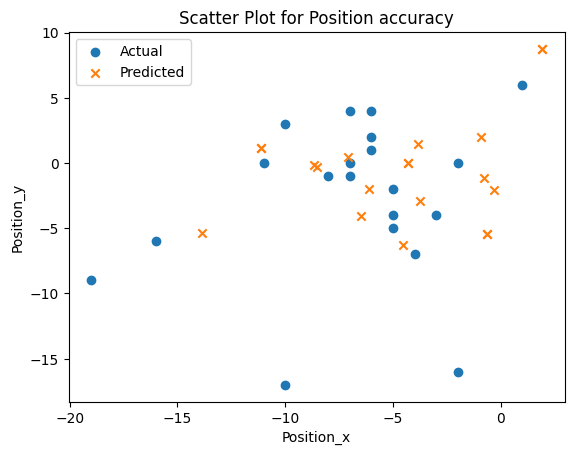

In [955]:
plt.scatter(y_test_position['position_x'], y_test_position['position_y'], label='Actual')
plt.scatter(y_pred_position[:, 0], y_pred_position[:, 1], label='Predicted', marker='x')
plt.xlabel('Position_x')
plt.ylabel('Position_y')
plt.title('Scatter Plot for Position accuracy')
plt.legend()
plt.show()


# Comments

Accuracy for landing orientation is about %50, which is expected from a coin flip.

Accuracy for landing position is about %75.

Model works pretty well!